# Example use of local_pcangsd

Here, we use some maize low-coverage data from the paper [Calfee et al. 2021](https://doi.org/10.1371/journal.pgen.1009810) on chromosome 4 where an inversion has been identified.

The starting file format is a genotype likelihood file (beagle format) that can be produced using `ANGSD`.

After the conversion, we subset chr4 between 150 and 200 Mb to reduce the dataset.

In [1]:
import os
import local_pcangsd as lp
import lostruct
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import pandas as pd
import numpy as np

JAX Backend Enabled -- To disable set JAX_BACKEND=None before loading lostruct


In [2]:
input = "data/hilo/analyses/hilo_chr4.beagle.gz" # input genotype likelihood file
store = "data/hilo/analyses/hilo_chr4.zarr" # where to store the transformed file

Now we produce an on-disk format of the genotype likelihoods.

`local_pcangsd` functions work with an `xarray.Dataset` to avoid loading all genotype likelihoods into memory.

The Dataset is stored as a zarr file.

Run the following only once.

In [3]:
if not os.path.exists(store):
	lp.beagle_to_zarr(input, store, chunksize=100000)

In [4]:
ds = lp.load_dataset(store, chunks=100000) # open the Dataset
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
	ds = ds.sel({'variants': (ds.variant_position > 165e6) & (ds.variant_position < 195e6)})
ds

<xarray.Dataset>
Dimensions:              (variants: 687732, alleles: 2, samples: 453,
                          genotypes: 3)
Dimensions without coordinates: variants, alleles, samples, genotypes
Data variables:
    allele               (variants, alleles) int8 dask.array<chunksize=(68148, 2), meta=np.ndarray>
    genotype_likelihood  (variants, samples, genotypes) float64 dask.array<chunksize=(68148, 453, 3), meta=np.ndarray>
    sample_id            (samples) object dask.array<chunksize=(453,), meta=np.ndarray>
    variant_contig       (variants) int64 dask.array<chunksize=(68148,), meta=np.ndarray>
    variant_contig_name  (variants) object dask.array<chunksize=(68148,), meta=np.ndarray>
    variant_position     (variants) int64 dask.array<chunksize=(68148,), meta=np.ndarray>
Attributes:
    contigs:  ['4']

The dataset is similar in structure to the sgkit format.

We now create windows variables, using sgkit functions internally.
Windows with less than `min_variant_number` variants are dropped,
as well as associated variants.

In [5]:
ds = lp.window(ds, type='position', size=100_000, min_variant_number = 500)
ds

<xarray.Dataset>
Dimensions:              (windows: 297, variants: 687732, alleles: 2,
                          samples: 453, genotypes: 3)
Dimensions without coordinates: windows, variants, alleles, samples, genotypes
Data variables:
    window_contig        (windows) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    window_start         (windows) int64 0 2003 3663 ... 681434 684444 686280
    window_stop          (windows) int64 2003 3663 5250 ... 684444 686280 687732
    allele               (variants, alleles) int8 dask.array<chunksize=(68148, 2), meta=np.ndarray>
    genotype_likelihood  (variants, samples, genotypes) float64 dask.array<chunksize=(68148, 453, 3), meta=np.ndarray>
    sample_id            (samples) object dask.array<chunksize=(453,), meta=np.ndarray>
    variant_contig       (variants) int64 dask.array<chunksize=(68148,), meta=np.ndarray>
    variant_contig_name  (variants) object dask.array<chunksize=(68148,), meta=np.ndarray>
    variant_position     (variants) int64 dask.array<chunksize=(68148,), meta=np.ndarray>
    window_used          (windows) bool True True True True ... True True True
Attributes:
    contigs:  ['4']

We compute PCAngsd on each window. This step is parallelized by default through `dask`.
Each PCAngsd process still uses a relatively large amount of memory, so be careful to scale accordingly.

In [6]:
%%time
pca_zarr_store = lp.pca_window(
	ds,
	store='data/hilo/hilo_local_pcangsd.zarr', # where to store the result
	tmp_folder='./tmp_local_pcangsd', # need a tmp folder, /tmp/tmp_local_pcangsd is default
	k=5, # number of PCs to retain
	min_maf=.05, # applied on each window
)

CPU times: user 2h 16min, sys: 2h 44s, total: 4h 16min 45s
Wall time: 16min 29s


The produced PCA result is also stored as a `xarray.Dataset` for easy access.
It can be loaded using the `xarray` module.

In [8]:
ds_pca = lp.load_dataset('data/hilo/hilo_local_pcangsd.zarr')
ds_pca

<xarray.Dataset>
Dimensions:              (windows: 293, samples_0: 453, samples_1: 453,
                          samples: 453, PCs: 5, variants: 687732)
Coordinates:
  * windows              (windows) int64 0 1 2 3 4 5 ... 291 292 293 294 295 296
Dimensions without coordinates: samples_0, samples_1, samples, PCs, variants
Data variables:
    C                    (windows, samples_0, samples_1) float32 dask.array<chunksize=(100, 227, 227), meta=np.ndarray>
    sample_id            (windows, samples) <U453 dask.array<chunksize=(100, 453), meta=np.ndarray>
    total_variance       (windows) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    vals                 (windows, PCs) float32 dask.array<chunksize=(100, 5), meta=np.ndarray>
    variant_contig       (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_contig_name  (variants) <U1 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position     (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_used         (variants) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    vectors              (windows, PCs, samples) float32 dask.array<chunksize=(100, 5, 453), meta=np.ndarray>
    window_contig        (windows) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    window_start         (windows) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    window_stop          (windows) int64 dask.array<chunksize=(100,), meta=np.ndarray>
Attributes:
    contigs:  ['4']

Now we transform the result into a format understandable by the `lostruct` python module, i.e. a `numpy.array`.
First dimension of the lostruct array is for windows.
Each element contains the covariance matrix, the total variance, the eigen values and the eigen vectors (second dimension of 4).

In [9]:
results = lp.to_lostruct(ds_pca)

In [10]:
print(f"Results on {results.shape[0]} windows")

Results on 293 windows


With the `lostruct` module, we compute the distance between window PCAs.
Then we perform MDS on those distances.

In [11]:
pc_dists = lostruct.get_pc_dists(results, jax=False)

In [12]:
mds = pcoa(pc_dists)

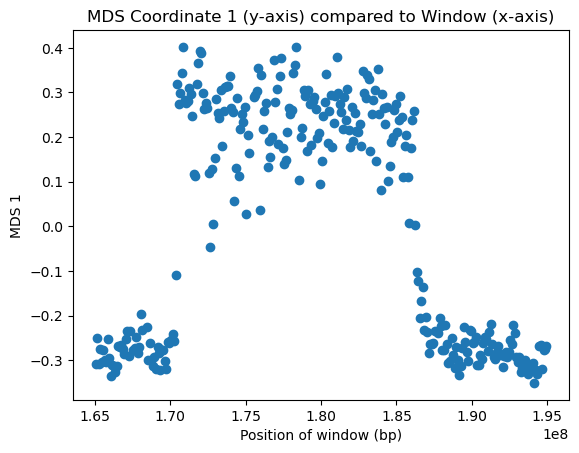

In [13]:
window_center = lp.get_window_center(ds_pca)

plt.figure()
plt.scatter(x=window_center, y=mds.samples["PC1"])
_ = plt.title("MDS Coordinate 1 (y-axis) compared to Window (x-axis)")
_ = plt.xlabel("Position of window (bp)")
_ = plt.ylabel("MDS 1")

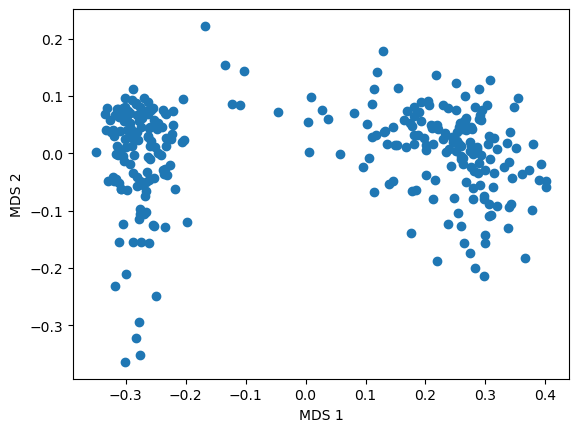

In [14]:
plt.figure()
plt.scatter(x=mds.samples["PC1"], y=mds.samples["PC2"])
_ = plt.xlabel("MDS 1")
_ = plt.ylabel("MDS 2")

In [15]:
mds_12 = mds.samples.loc[:, ["PC1", "PC2"]].copy()
xy = mds_12.to_numpy()
corners = lostruct.corners(xy, prop=0.05) # no k parameter implemented yet
print(corners[:10])

[[  1  10  85]
 [  3 227  86]
 [  4 228 101]
 [  8 233 102]
 [ 21 235 103]
 [ 33 247 115]
 [ 34 258 139]
 [ 35 263 147]
 [ 39 273 150]
 [ 41 275 154]]


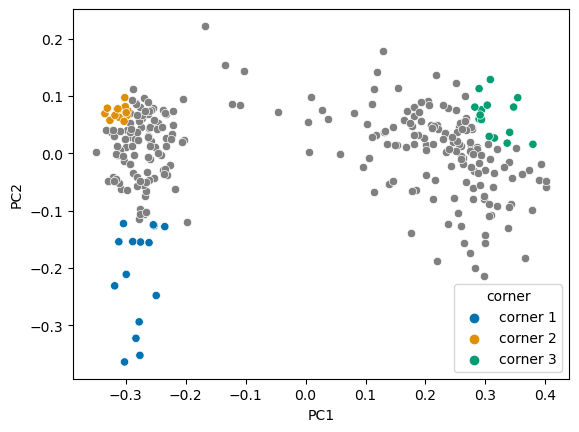

In [16]:
mds_12['corner'] = 'other'
mds_12['window'] = range(pc_dists.shape[0])
mds_12['window_center'] = window_center
for i in range(3):
	mds_12.iloc[corners[:,i], 2] = f'corner {i+1}'

_ = sns.scatterplot(
	data=mds_12[mds_12.corner=='other'], x="PC1", y="PC2", color='gray',
)
_ = sns.scatterplot(
	data=mds_12[mds_12.corner!='other'], x="PC1", y="PC2", hue="corner",
	hue_order=["corner 1", "corner 2", "corner 3"],
	palette='colorblind',
)

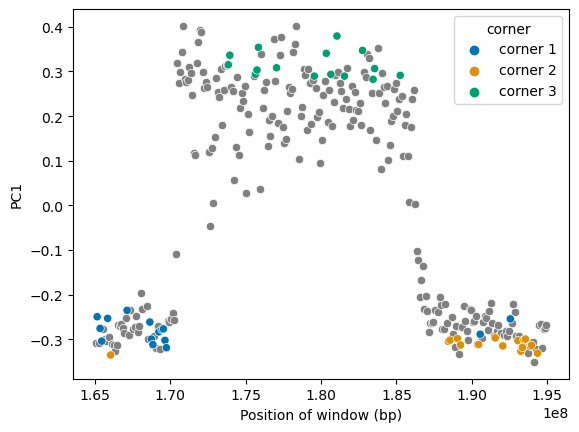

In [17]:
_ = sns.scatterplot(
	data=mds_12[mds_12.corner=='other'],
	x='window_center', y='PC1', color='gray',
)
_ = sns.scatterplot(
	data=mds_12[mds_12.corner!='other'],
	x="window_center", y="PC1", hue="corner",
	hue_order=["corner 1", "corner 2", "corner 3"],
	palette='colorblind',
)
_ = plt.xlabel("Position of window (bp)")

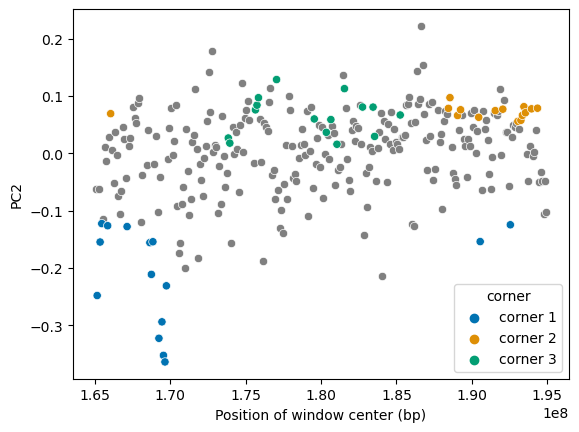

In [18]:
_ = sns.scatterplot(
	data=mds_12[mds_12.corner=='other'],
	x='window_center', y='PC2', color='gray',
)
_ = sns.scatterplot(
	data=mds_12[mds_12.corner!='other'],
	x="window_center", y="PC2", hue="corner",
	hue_order=["corner 1", "corner 2", "corner 3"],
	palette='colorblind',
)
_ = plt.xlabel("Position of window center (bp)")

Let's compute the PCA on the combined windows corresponding to the inversion.
All variants from the corner 2 identified windows (orange above) are merged together to compute a common PCA.

In [19]:
corner2_pca = lp.pcangsd_merged_windows(ds, corners[:,0], k=5)

EM (MAF) converged at iteration: 18
Using 15 principal components (MAP test).
Individual allele frequencies estimated (1).
Individual allele frequencies estimated (2). RMSE=0.052954635423965196
Individual allele frequencies estimated (3). RMSE=0.030298410198400915
Individual allele frequencies estimated (4). RMSE=0.04292128119198537
Individual allele frequencies estimated (5). RMSE=0.035023403504142625
Individual allele frequencies estimated (6). RMSE=0.03452851056704845
Individual allele frequencies estimated (7). RMSE=0.03445301610849434
Individual allele frequencies estimated (8). RMSE=0.034552101818399295
Individual allele frequencies estimated (9). RMSE=0.003930675798303843
Individual allele frequencies estimated (10). RMSE=0.0034876665122455302
Individual allele frequencies estimated (11). RMSE=0.02447393110163584
Individual allele frequencies estimated (12). RMSE=0.02448789994228479
Individual allele frequencies estimated (13). RMSE=0.005153988122297904
Individual allele frequen

In [20]:
meta = pd.read_csv('data/hilo/other_files/HILO_MAIZE55_PARV50_meta.tsv', sep='\t')
ids = pd.read_csv('data/hilo/other_files/HILO_MAIZE55_PARV50_ids.list', names=['ID'])
meta = meta.set_index(meta.ID).reindex(ids.ID)

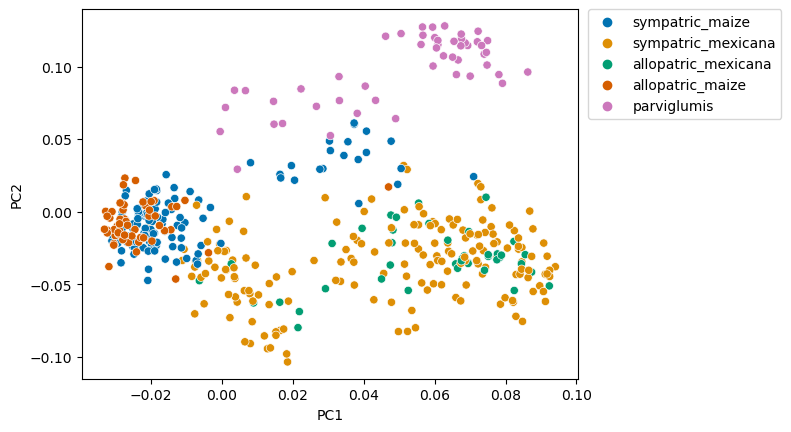

In [21]:
_ = sns.scatterplot(
	x=corner2_pca[3][0], y=corner2_pca[3][1],
	hue=meta['group'],
	palette="colorblind",
)
_ = plt.xlabel("PC1")
_ = plt.ylabel("PC2")
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)